# GR5293 - Proj1 - Group9
## Classification on the late payment of credit cards
#### Machine learning pipeline with random forest
* Feature Engineering
* Train validation test split
* K-fold cross validation
* Rank the feature importance to interpret the result and give the orientation of further dimension reduction to enhance the depoliability of our model, state its business value
* Plot the ranked feature importance barplot(horizontal), the AUC curve with cv iteration
* Plot the cv scores in feature selection (/w number of components)

#### Setup

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from matplotlib import pyplot as plt
import time
import os
import re
import gc
gc.enable()
print(os.getcwd())
mydir = os.getcwd() + "/"
%xmode plain
%matplotlib inline

/Users/kangshuoli/Documents/VScode_workspace/GR5293/EODS-Project1-Group9/doc
Exception reporting mode: Plain


#### Read in data

In [24]:
fraud_df = pd.read_csv(
    '../data/fraud_cleaned_ver2.csv', 
    header = 0
)
fraud_df = fraud_df.iloc[:,1:]
fraud_df.shape

(126835, 154)

In [25]:
fraud_df

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,67500.0,80865.0,5881.5,67500.0,0.031329,-13439.0,-2717.0,-311.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,225000.0,918468.0,28966.5,697500.0,0.016612,-14086.0,-3028.0,-643.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,189000.0,773680.5,32778.0,679500.0,0.010006,-14583.0,-203.0,-615.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126830,0.0,3.0,81000.0,269550.0,11871.0,225000.0,0.009175,-12961.0,-1046.0,-1398.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
126831,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327.0,-236.0,-8456.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
126832,0.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966.0,-7921.0,-6737.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
126833,1.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961.0,-4786.0,-2562.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Split the features and label

In [26]:
feature_df = fraud_df.iloc[:,1:]
response_df = fraud_df.loc[:,"TARGET"].astype(int)
feature_df.shape

(126835, 153)

In [27]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126835 entries, 0 to 126834
Columns: 153 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: float64(153)
memory usage: 148.1 MB


#### Post-process the data
##### Make corrections on data type
* Extract columns with "FLAG", "TYPE" in their names as categorical data
* Some columns with all integers but have "CNT", "DAYS" in their names would not be converted
* Unique value <= 10 can be interpreted as categorical

In [28]:
for name in feature_df.columns:
    print(name)

CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_2
APARTMENTS_AVG
YEARS_BEGINEXPLUATATION_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
LIVINGAREA_AVG
APARTMENTS_MODE
YEARS_BEGINEXPLUATATION_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
LIVINGAREA_MODE
APARTMENTS_MEDI
YEARS_BEGINEXPLUATATION_MEDI
ELEVATORS_MEDI
ENTRANCES_MEDI
FLOORSMAX_MEDI
LIVINGAREA_MEDI
TOTALAREA_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
NAME_CONTRACT_TYPE_Revolving loans
CODE_GENDER_M
CODE_GENDER

In [29]:
for name in feature_df.columns:
    print(name, len(feature_df[name].unique()))

CNT_CHILDREN 13
AMT_INCOME_TOTAL 1439
AMT_CREDIT 4601
AMT_ANNUITY 11703
AMT_GOODS_PRICE 764
REGION_POPULATION_RELATIVE 79
DAYS_BIRTH 16013
DAYS_EMPLOYED 11189
DAYS_REGISTRATION 13736
DAYS_ID_PUBLISH 6023
FLAG_MOBIL 2
FLAG_EMP_PHONE 2
FLAG_WORK_PHONE 2
FLAG_CONT_MOBILE 2
FLAG_PHONE 2
FLAG_EMAIL 2
CNT_FAM_MEMBERS 16
REGION_RATING_CLIENT 3
REGION_RATING_CLIENT_W_CITY 3
HOUR_APPR_PROCESS_START 24
REG_REGION_NOT_LIVE_REGION 2
REG_REGION_NOT_WORK_REGION 2
LIVE_REGION_NOT_WORK_REGION 2
REG_CITY_NOT_LIVE_CITY 2
REG_CITY_NOT_WORK_CITY 2
LIVE_CITY_NOT_WORK_CITY 2
EXT_SOURCE_2 75240
APARTMENTS_AVG 5223
YEARS_BEGINEXPLUATATION_AVG 843
ELEVATORS_AVG 8902
ENTRANCES_AVG 1880
FLOORSMAX_AVG 863
LIVINGAREA_AVG 8424
APARTMENTS_MODE 3699
YEARS_BEGINEXPLUATATION_MODE 783
ELEVATORS_MODE 8650
ENTRANCES_MODE 1634
FLOORSMAX_MODE 502
LIVINGAREA_MODE 8516
APARTMENTS_MEDI 4080
YEARS_BEGINEXPLUATATION_MEDI 806
ELEVATORS_MEDI 8697
ENTRANCES_MEDI 1650
FLOORSMAX_MEDI 526
LIVINGAREA_MEDI 8496
TOTALAREA_MODE 5165
OBS_3

In [30]:
categorical_col_list = []
for name in feature_df.columns:
    if len(feature_df[name].unique()) <= 10:
        categorical_col_list.append(name)
        feature_df[name] = feature_df[name].astype(int)

/var/folders/tz/1kfts8hs47xb2vd2_6cggx300000gn/T/ipykernel_36835/4143337950.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df[name] = feature_df[name].astype(int)


In [31]:
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126835 entries, 0 to 126834
Columns: 153 entries, CNT_CHILDREN to EMERGENCYSTATE_MODE_Yes
dtypes: float64(37), int64(116)
memory usage: 148.1 MB


#### Delete some special columns by screening
* Drop last column called EMERGENCYSTATE_MODE_Yes since it only has one level
* Drop predictors with AVG MODE MEDI, only keep medians

In [32]:
import re
pattern_avg_mode = re.compile('(.*_AVG$|.*_MODE$)')
dup_col_list = []
for name in feature_df.columns:
    if re.search(pattern_avg_mode, name):
        dup_col_list.append(name)

feature_df.drop(
    dup_col_list,
    inplace = True, 
    axis = 1
)

/Users/kangshuoli/miniforge3/envs/eods-s22/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
dup_col_list

['APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'TOTALAREA_MODE']

##### Stadardize
* Only standardize columns with non-categorical data

In [34]:
from sklearn.preprocessing import MinMaxScaler
# instantiate the scalar
minmax_scalar = MinMaxScaler(
    feature_range = (0, 1)
)
# split the feature_df into categorical and non-categorical subdf
feature_df_non_categorical = feature_df[[name for name in feature_df.columns if name not in categorical_col_list]]
feature_df_categorical = feature_df[[name for name in feature_df.columns if name in categorical_col_list]]

# only transform non_categorical df
feature_df_non_categorical_minmax = minmax_scalar.fit_transform(X = feature_df_non_categorical) # return np.ndarray
# convert it into a dataframe
feature_df_std_categorical_minmax = pd.DataFrame(
    data = feature_df_non_categorical_minmax, 
    columns = feature_df_non_categorical.columns
)
# concatenate categorical df and non-categorical df
feature_df_minmax = pd.concat([feature_df_std_categorical_minmax, feature_df_categorical], axis = 1)
# dtype conversion
for name in list(feature_df_minmax.columns):
    if name in categorical_col_list:
        feature_df_minmax[name] = feature_df_minmax[name].astype(int)

In [35]:
feature_df_minmax

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.000000,0.001512,0.090287,0.088480,0.076404,0.256321,0.898242,0.964437,0.840893,0.676385,...,0,0,0,0,0,0,0,1,0,0
1,0.000000,0.002089,0.311736,0.131445,0.270787,0.045016,0.481395,0.933676,0.948273,0.955579,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.000358,0.008955,0.014961,0.005618,0.429796,0.671213,0.848314,0.986436,0.507403,...,0,0,0,0,0,0,0,0,0,0
3,0.052632,0.001704,0.218094,0.105146,0.162921,0.226010,0.634288,0.830951,0.971956,0.250343,...,0,0,0,0,0,0,1,0,0,0
4,0.000000,0.001396,0.181943,0.120036,0.158427,0.134537,0.605924,0.988667,0.973177,0.686155,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126830,0.157895,0.000473,0.056067,0.038359,0.044944,0.123030,0.698493,0.941603,0.939027,0.422989,...,0,0,0,0,0,0,0,1,0,0
126831,0.000000,0.001127,0.052360,0.099643,0.044944,0.446855,0.905890,0.986824,0.631193,0.697451,...,0,0,0,0,0,0,0,1,0,0
126832,0.000000,0.001089,0.157969,0.109101,0.134831,0.065247,0.584066,0.557782,0.706167,0.213860,...,0,0,0,0,0,0,1,0,0,0
126833,0.000000,0.001243,0.081175,0.070917,0.068539,0.069553,0.755564,0.732805,0.888259,0.857884,...,0,0,0,0,0,0,0,1,0,0


#### Modeling

In [36]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#### Train test split

In [37]:
def train_test_split_with_shuffle(feature_df_, response_df_ = response_df, test_size_ = 0.25):
    '''
    Implement train test split function and shuffle all the data
    Default using test_ratio = 0.25 and standardized dataframe
    Return global variables
    '''
    globals()['feature_train'], globals()['feature_test'], globals()['response_train'], globals()['response_test'] = train_test_split(
        feature_df_, 
        response_df_, 
        test_size = test_size_, 
        shuffle = True, 
        random_state = 42, 
        stratify = response_df_
    )
    globals()['response_train'] = pd.DataFrame(globals()['response_train'])
    globals()['response_test'] = pd.DataFrame(globals()['response_test'])
    list_p1 = ["feature", "response"]
    list_p2 = ["train", "test"]
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            print(f'The Size of {temp_var} is: {globals()[temp_var].shape}')

    # reshape the index
    # make them start from 0 and end at their shape[0] - 1
    for p1 in list_p1:
        for p2 in list_p2:
            temp_var = p1 + '_' + p2
            globals()[temp_var].index = np.arange(globals()[temp_var].shape[0], dtype = int)
    pass

train_test_split_with_shuffle(feature_df_ = feature_df_minmax, response_df_ = response_df)

The Size of feature_train is: (95126, 140)
The Size of feature_test is: (31709, 140)
The Size of response_train is: (95126, 1)
The Size of response_test is: (31709, 1)


#### Feature Engineering
* Feature selection by RFE / SelectFromModel / PCA / LASSO / LLE
* Extreme imbalanced data -> resampling
* Only 6% of data is fraudulent this would cause the classifier onlt predict no fraudulent and get the result of 90%+ accuracy

##### Visualize the labels

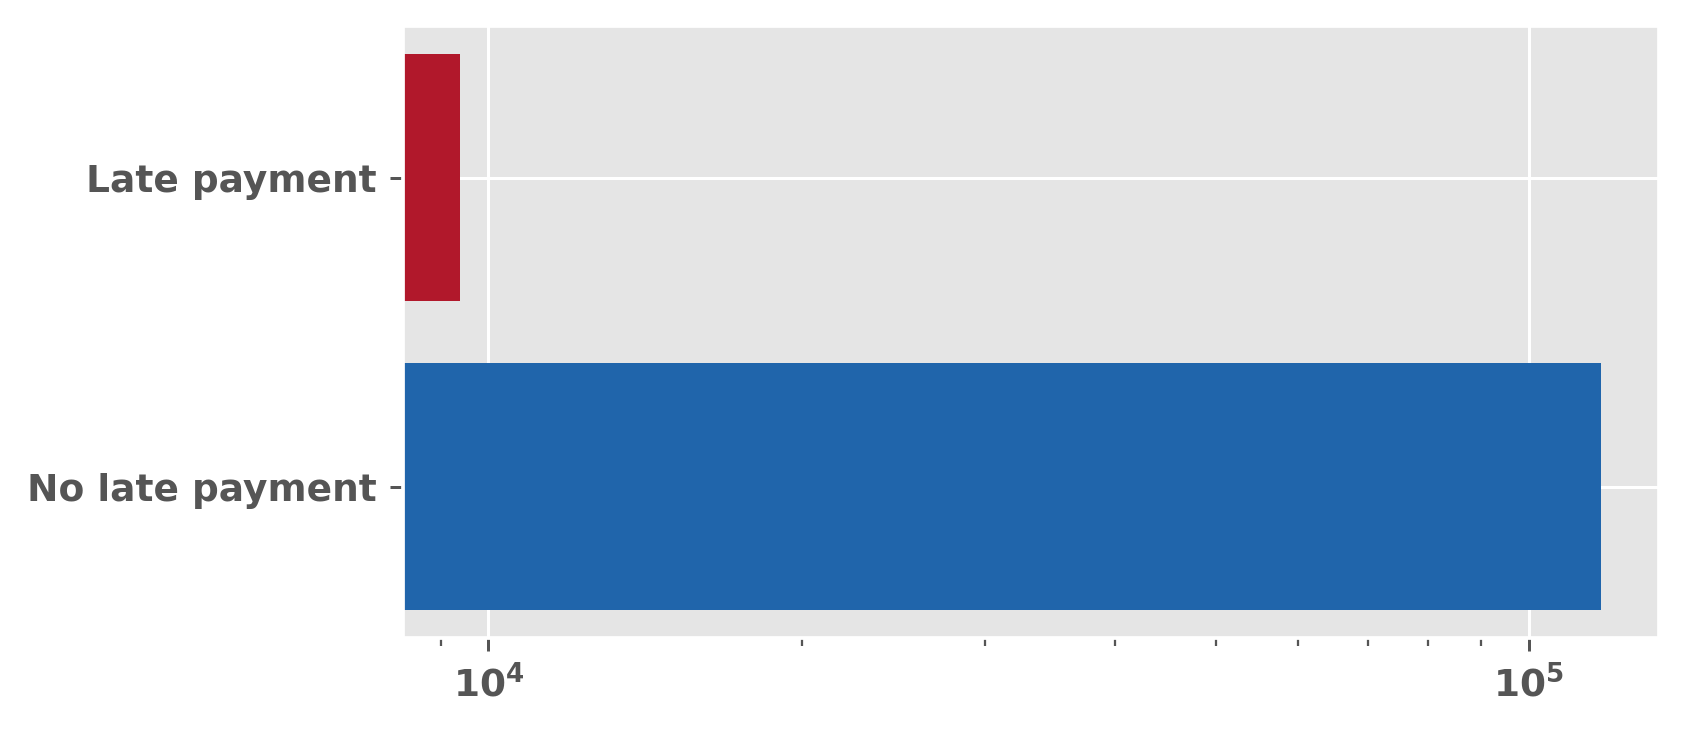

In [38]:
from matplotlib import cm
plt.style.use('ggplot')
plt.rcParams["font.weight"] = "bold"
my_colormap = cm.get_cmap(name = 'RdBu')
color_value = np.linspace(start = 0.9, stop = 0.1, num = 2)
fig, ax = plt.subplots(1, 1, figsize = (6,3), dpi = 270)
for i in np.arange(2):
    ax.barh(
        y = i, 
        width = response_df[response_df == i].shape[0], 
        label = i, 
        color = my_colormap(color_value[i])
    )
ax.set_yticks(np.arange(2), ["No late payment", "Late payment"])
ax.set_xscale('log')
# ax.set_xlabel("Count")
plt.show()

#### Resampling after train test split
* Random Under-Sampling / Random Over-Sampling / Random under-sampling with imblearn / Random over-sampling with imblearn / Under-sampling: Tomek links / Synthetic Minority Oversampling Technique (SMOTE) / NearMiss / 

Use undersampling here since the amount of data is large. (Low F1 score)
>Tomek links can extract the data from majority class "0" that are close to opposite classes. 
Try Synthetic Minority Oversampling Technique (SMOTE)

In [39]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE

sampler = RandomUnderSampler(
    sampling_strategy = "auto", 
    random_state = 42
)

# sampler = RandomOverSampler(
#     sampling_strategy = "auto", 
#     random_state = 42
# )

# sampler = SMOTE(
#     sampling_strategy = "auto", 
#     random_state = 42, 
#     n_jobs = -1, 
#     k_neighbors = 5
# )

feature_res, response_res = sampler.fit_resample(X = feature_train, y = response_train)

In [40]:
feature_res

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,ORGANIZATION_TYPE_University,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes
0,0.000000,0.001127,0.089151,0.072675,0.060674,0.429796,0.345623,0.455337,0.859691,0.590139,...,0,0,0,0,0,0,1,0,0,0
1,0.000000,0.002474,0.184000,0.214774,0.157303,1.000000,0.386428,0.937025,0.703986,0.701572,...,0,0,0,0,0,0,1,0,0,0
2,0.000000,0.002666,0.459888,0.195190,0.382022,0.282797,0.429232,0.898504,0.904745,0.813006,...,0,0,0,0,0,0,1,0,0,1
3,0.052632,0.002474,0.243407,0.214968,0.224719,0.157398,0.729768,0.978339,0.981376,0.284689,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000935,0.264045,0.106113,0.264045,0.248124,0.660655,0.916536,0.850052,0.473821,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14085,0.000000,0.002089,0.094382,0.065274,0.094382,0.248124,0.459594,0.848314,0.938154,0.936346,...,0,0,0,0,0,0,1,0,0,0
14086,0.000000,0.000473,0.148584,0.109066,0.101124,0.065247,0.950177,0.987383,0.858034,0.815143,...,0,0,0,0,0,0,0,0,1,0
14087,0.000000,0.002089,0.162584,0.118506,0.129213,0.245631,0.533957,0.952155,0.564637,0.368646,...,0,0,0,0,0,0,0,1,0,0
14088,0.000000,0.000742,0.130101,0.059772,0.106742,0.254009,0.320568,0.694451,0.643100,0.623264,...,0,0,0,0,0,0,0,1,0,0


In [41]:
response_res = np.array(response_res).ravel()

##### Feature Selection

In [42]:
random_state_ = 42
# SelectFromModel
sfm_clf = SelectFromModel(
    estimator = RandomForestClassifier(
        # max_depth = 10, 
        # n_estimators = 600, 
        # class_weight = "balanced"
    ), 
    threshold = None, 
    importance_getter = "auto", 
    norm_order = 1
)
sfm_clf.fit(X = feature_res, y = response_res)
feature_selected_sfm_clf = [name for i, name in enumerate(feature_res.columns) if sfm_clf.get_support()[i] == True]
feature_df_sfm_clf = pd.DataFrame(data = sfm_clf.transform(feature_res), columns = feature_selected_sfm_clf )
print('Selector------------------------------------------------------------')
print(f'Feature Importance Threshold: {sfm_clf.threshold_:0.4f} \nSelected Features: \n{feature_df_sfm_clf.columns}\n Number of Selected Features: {len(feature_selected_sfm_clf)}')


# PCA (w/o std) Not working
variance_explained = 0.85
pca_clf = PCA(
    n_components = variance_explained, 
    svd_solver = "auto", 
    random_state = random_state_
)
pca_clf.fit(X = feature_res, y = response_res)
feature_df_pca_clf = pd.DataFrame(pca_clf.transform(feature_res), columns = np.arange(pca_clf.n_components_, dtype = int))
print('PCA-----------------------------------------------------------------')
print(f'Variance explained: {np.sum(pca_clf.explained_variance_ratio_):0.4f} \nNumber of Components: {pca_clf.n_components_}')

Selector------------------------------------------------------------
Feature Importance Threshold: 0.0071 
Selected Features: 
Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2',
       'APARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Secondary / secondary special'],
      dtype='object')
 Number of Selected Features: 28
PCA-----------------------------------------------------------------
Variance explained: 0.8530 
Number 

In [43]:
params_rf_clf = {
    'n_estimators': [400], 
    'max_depth': [None, 4, 6, 8, 10, 12, 15], 
    'min_samples_split': [2], 
    'max_features': ["sqrt"], 
    'max_leaf_nodes': [None], 
    # 'min_impurity_decrease': [0.0, 0.1, 0.2, 0.5], 
    'n_jobs': [-1], 
    'bootstrap': [True], 
    'oob_score': [True], 
    'random_state': [0], 
    'verbose': [0], 
    'max_samples': [None], 
    # 'class_weight': [{"balanced"}]
}


# gridsearch_clf = GridSearchCV(
#     estimator = RandomForestClassifier(), 
#     param_grid = params_rf_clf, 
#     scoring = "f1_micor",
#     cv = 10, 
#     verbose = 1, 
#     n_jobs = -1
# )

randomsearch_clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(), 
    param_distributions = params_rf_clf, 
    n_iter = 5, 
    scoring = "roc_auc",
    cv = 10, 
    verbose = 2, 
    n_jobs = -1,
    return_train_score = True
)

randomsearch_clf.fit(X = feature_df_sfm_clf, y = np.array(response_res).ravel())
best_rf_clf = randomsearch_clf.best_estimator_
best_score_clf = randomsearch_clf.best_score_
best_params_clf = randomsearch_clf.best_params_
training_score = randomsearch_clf.cv_results_
print(f'The best params: \n{best_params_clf}\nBest Score: {best_score_clf:0.4f}')

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=400, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=   6.2s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=400, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=   6.2s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=400, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=   6.2s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples_split=2, n_estimators=400, n_jobs=-1, oob_score=True, random_state=0, verbose=0; total time=   6.2s
[CV] END bootstrap=True, max_depth=8, max_features=sqrt, max_leaf_nodes=None, max_samples=None, min_samples

In [24]:
# RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

##### Prediction

In [44]:
# # resample test data
# feature_test_res, response_test_res = sampler.fit_resample(X = feature_test, y = response_test)

# feature selection on test set
feature_test_sfm = pd.DataFrame(
    data = sfm_clf.transform(feature_test), 
    columns = feature_df_sfm_clf.columns
)

from sklearn.metrics import auc, roc_curve
response_pred_clf = best_rf_clf.predict(feature_test_sfm)
pred_accu = accuracy_score(y_true = response_test, y_pred = response_pred_clf)
# pred_f1 = f1_score(response_pred_clf, response_test, labels = ["Limited shares", "Some shares", "Many shares", "Numerous shares"], average = 'macro')
pred_f1 = f1_score(y_true = response_test, y_pred = response_pred_clf)
pred_proba = best_rf_clf.predict_proba(feature_test_sfm)[:,1]
pred_auc = roc_auc_score(y_true = response_test, y_score = pred_proba)
print(f'Model params: \n{best_params_clf}\nModel performance:\nAccuracy: {pred_accu:0.4f}\nF1 Score: {pred_f1:0.4f}\nAUC: {pred_auc:0.4f}')

Model params: 
{'verbose': 0, 'random_state': 0, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 400, 'min_samples_split': 2, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True}
Model performance:
Accuracy: 0.6519
F1 Score: 0.2148
AUC: 0.6961


In [45]:
print(f'Recall: {recall_score(y_true = response_test, y_pred = response_pred_clf):0.4f}')
print(f'Precision: {precision_score(y_true = response_test, y_pred = response_pred_clf):0.4f}')

Recall: 0.6428
Precision: 0.1290


In [46]:
response_pred_alt = best_rf_clf.predict(feature_df_sfm_clf)
pred_accu_alt = accuracy_score(y_true = response_res, y_pred = response_pred_alt)
# pred_f1 = f1_score(response_pred_clf, response_test, labels = ["Limited shares", "Some shares", "Many shares", "Numerous shares"], average = 'macro')
pred_f1_alt = f1_score(y_true = response_res, y_pred = response_pred_alt)
pred_proba_alt = best_rf_clf.predict_proba(feature_df_sfm_clf)[:,1]
pred_auc_alt = roc_auc_score(y_true = response_res, y_score = pred_proba_alt)
print(f'Model params: \n{best_params_clf}\nModel performance:\nAccuracy: {pred_accu_alt:0.4f}\nF1 Score: {pred_f1_alt:0.4f}\nAUC: {pred_auc_alt:0.4f}')

Model params: 
{'verbose': 0, 'random_state': 0, 'oob_score': True, 'n_jobs': -1, 'n_estimators': 400, 'min_samples_split': 2, 'max_samples': None, 'max_leaf_nodes': None, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True}
Model performance:
Accuracy: 0.8972
F1 Score: 0.8995
AUC: 0.9639


In [47]:
response_test.sum() / response_test.shape[0]

TARGET    0.07408
dtype: float64

In [48]:
response_res.sum() / response_res.shape[0]

0.5